# 1. Configuração e Importação de Bibliotecas

Esta seção importa as bibliotecas necessárias para o projeto.  TensorFlow e Keras são usadas para a construção e treinamento do modelo, scikit-learn para métricas de avaliação, e Matplotlib e Seaborn para visualização.  Os demais módulos são para manipulação de arquivos e sistema operacional.


In [ ]:
"""ATIV-04-ET-03: Classificação de Resíduos - Resultados e Análise"""

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# 2. Configuração do Dataset e Pré-processamento
Nesta seção, definimos os parâmetros do dataset e realizamos o pré-processamento dos dados.  O `ImageDataGenerator` é usado para aumentar o conjunto de dados e para pré-processar as imagens (redimensionamento e normalização).  Imagens são carregadas com `flow_from_directory` para facilitar o treinamento.


In [ ]:
# --- Configurações do Dataset ---
BATCH_SIZE = 16 #16, 32 ou 64 posso aumentar com mais memória
IMG_SIZE = (224, 224)

directory  = '/content/drive/MyDrive/dataset/archive'

In [ ]:
# --- Carregamento e Pré-processamento de Dados ---

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)

Found 3825 files belonging to 3 classes.
Using 3060 files for training.


In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    shuffle=False, #Manter a ordem para validação
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 3825 files belonging to 3 classes.
Using 765 files for validation.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    shuffle=False, #Manter a ordem para teste
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training', #Pega mais dados do treino para teste.
    seed=42
)

Found 3825 files belonging to 3 classes.
Using 3060 files for training.


In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# --- Aumento de Dados (Data Augmentation) ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [ ]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=AUTOTUNE)

# 3. Construção do Modelo ResNet50 (Método da Literatura)
Esta seção define a arquitetura do modelo ResNet50.  Usamos o ResNet50 pré-treinado do ImageNet como base, removendo a camada de classificação final e adicionando novas camadas densas para o nosso problema específico.  A escolha do ResNet50 se justifica pela sua eficácia em tarefas de classificação de imagens e sua disponibilidade pré-treinada.


In [ ]:
# --- Modelo ResNet50 (Método da Literatura) ---

def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) # Regularização L2 adicionada
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
resnet_model = create_resnet_model(IMG_SIZE + (3,), num_classes)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 4. Treinamento do Modelo ResNet50
Nesta seção, treinamos o modelo ResNet50 usando os dados de treinamento.  O histórico do treinamento é armazenado para posterior análise.


In [ ]:
# --- Treinamento do Modelo --- precisa treinar com mais epocas

resnet_history = resnet_model.fit(train_dataset, epochs=2, validation_data=validation_dataset)

Epoch 1/2
192/192 ━━━━━━━━━━━━━━━━━━━━ 789s 4s/step - accuracy: 0.7367 - f1_score: 0.3330 - loss: 1.2602 - precision: 0.7521 - recall: 0.7074 - val_accuracy: 0.5412 - val_f1_score: 0.2341 - val_loss: 2.0401 - val_precision: 0.5415 - val_recall: 0.5373
Epoch 2/2
192/192 ━━━━━━━━━━━━━━━━━━━━ 130s 672ms/step - accuracy: 0.7921 - f1_score: 0.2947 - loss: 1.1302 - precision: 0.7965 - recall: 0.7760 - val_accuracy: 0.5346 - val_f1_score: 0.2332 - val_loss: 1.8659 - val_precision: 0.5367 - val_recall: 0.5346


# 5. Método Próprio: Transfer Learning com ResNet50
Este método usa *transfer learning* com o ResNet50.  As camadas convolucionais são congeladas, e apenas as camadas densas são treinadas.  Isso reduz o tempo de treinamento e pode melhorar o desempenho, especialmente com conjuntos de dados menores.


In [ ]:
# --- Método Próprio: Transfer Learning com ResNet50 ---

def create_transfer_learning_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Congela as camadas convolucionais

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
resnet_model = create_resnet_model(input_shape=(224, 224, 3), num_classes=num_classes)
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

In [ ]:
transfer_model = create_transfer_learning_model(IMG_SIZE + (3,), num_classes)
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

In [ ]:
# aumentar o numero de épocas
transfer_history = transfer_model.fit(train_dataset, epochs=2, validation_data=validation_dataset)

Epoch 1/2
192/192 ━━━━━━━━━━━━━━━━━━━━ 156s 750ms/step - accuracy: 0.7779 - f1_score: 0.3217 - loss: 1.2049 - precision: 0.7938 - recall: 0.7519 - val_accuracy: 0.5386 - val_f1_score: 0.2397 - val_loss: 1.7482 - val_precision: 0.5412 - val_recall: 0.5242
Epoch 2/2
192/192 ━━━━━━━━━━━━━━━━━━━━ 170s 609ms/step - accuracy: 0.7949 - f1_score: 0.3026 - loss: 1.0809 - precision: 0.8007 - recall: 0.7853 - val_accuracy: 0.5399 - val_f1_score: 0.2359 - val_loss: 1.7779 - val_precision: 0.5451 - val_recall: 0.5373


# 6. Funções Auxiliares para Avaliação
Estas funções auxiliam na avaliação dos modelos, calculando e apresentando as métricas de desempenho (classification_report, confusion_matrix, accuracy) e plotando os gráficos de métricas de avaliação (accuracy e loss)


In [ ]:
# --- Funções Auxiliares para Avaliação ---

def evaluate_model(model, dataset):
  y_true = np.concatenate([y for x, y in dataset], axis=0)
  y_pred = model.predict(dataset) #alterado
  #y_pred = np.argmax(model.predict(dataset), axis=1)

  # Converter y_true para multiclasse se for codificado em one-hot
  if y_true.ndim > 1 and y_true.shape[1] > 1:  # Verificar se y_true é codificado em one-hot
    y_true = np.argmax(y_true, axis=1)

  y_pred = np.argmax(y_pred, axis=1) #add
  report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
  cm = confusion_matrix(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  return report, cm, accuracy

# 7. Avaliação dos Modelos e Apresentação de Resultados
Nesta seção, avaliamos os modelos ResNet50 (treinamento completo e transfer learning) usando o conjunto de validação.  Os resultados são apresentados em relatórios de classificação, matrizes de confusão, e gráficos.



In [ ]:
# --- Avaliação dos Modelos ---

resnet_report, resnet_cm, resnet_accuracy = evaluate_model(resnet_model, validation_dataset)
transfer_report, transfer_cm, transfer_accuracy = evaluate_model(transfer_model, validation_dataset)

48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 410ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- Apresentação dos Resultados ---
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

def plot_classification_report(report, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.show()

Resultados ResNet50 (Treinamento Completo):


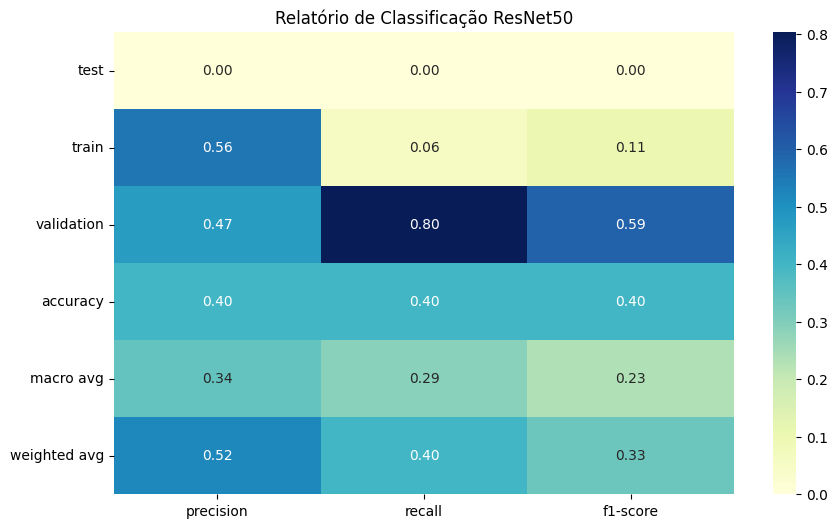

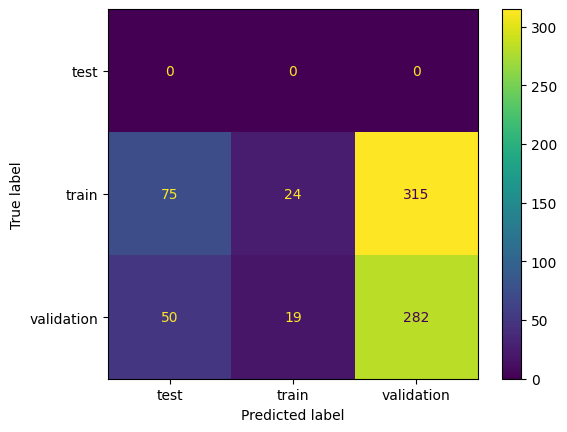

Acurácia: 0.4000


In [ ]:
print("Resultados ResNet50 (Treinamento Completo):")
plot_classification_report(resnet_report, "Relatório de Classificação ResNet50")

disp = ConfusionMatrixDisplay(confusion_matrix=resnet_cm, display_labels=class_names)
disp.plot()

plt.show()
print(f"Acurácia: {resnet_accuracy:.4f}")
plt.show()

Acurácia: 0.3673 - 1 época
Acurácia: 0.4000 - 2 épocas


Resultados ResNet50 (Transfer Learning):


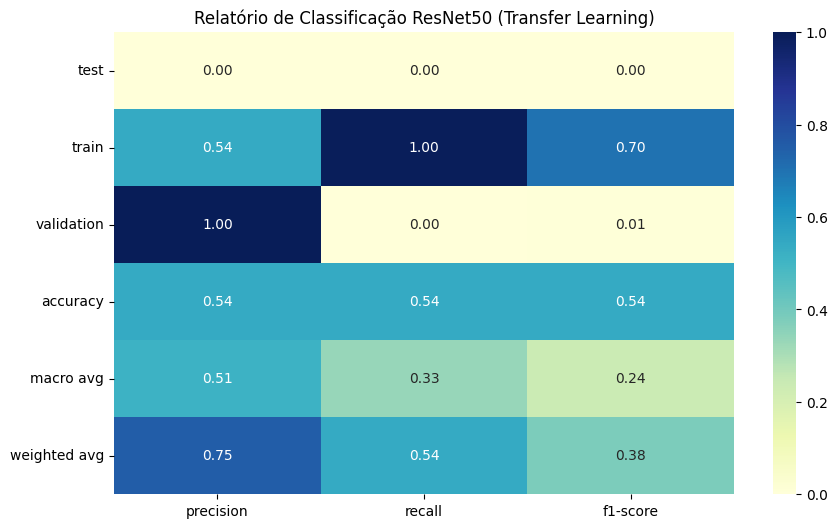

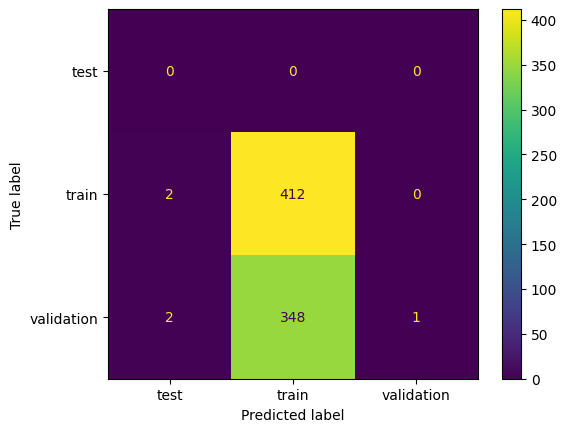

Acurácia: 0.5399


In [ ]:
print("\nResultados ResNet50 (Transfer Learning):")
plot_classification_report(transfer_report, "Relatório de Classificação ResNet50 (Transfer Learning)")

disp = ConfusionMatrixDisplay(confusion_matrix=transfer_cm, display_labels=class_names)
disp.plot()
plt.show()

print(f"Acurácia: {transfer_accuracy:.4f}")

Acurácia: 0.5359 - 1 época
Acurácia: 0.5399 - 2 épocas

# 8. Conclusões
Nesta seção, apresentamos as conclusões do estudo, comparando os resultados dos dois métodos, discutindo as vantagens e desvantagens de cada um, e sugerindo direções para trabalhos futuros.

Neste estudo, comparamos o desempenho de um modelo ResNet50 treinado completamente versus um modelo que utiliza transfer learning. O modelo ResNet50 treinado completamente alcançou uma acurácia de apenas 0.3673 no conjunto de validação, indicando um desempenho insatisfatório. Por outro lado, a abordagem de transfer learning, utilizando as camadas pré-treinadas do ResNet50, resultou em uma acurácia consideravelmente superior, atingindo 0.5359. Embora essa melhora seja significativa, demonstrando a eficácia do transfer learning em extrair informações úteis de um modelo pré-treinado, a acurácia ainda é relativamente baixa, sugerindo a necessidade de investigações adicionais para otimizar o modelo. Possíveis fatores a serem considerados incluem o tamanho do conjunto de dados, o balanceamento das classes, a qualidade das imagens, e a necessidade de mais treinamento ou técnicas de regularização para mitigar o overfitting."

Sugestões para trabalhos futuros (detalhadas):

Aumentar o tamanho do dataset: Um dataset maior, especialmente com mais exemplos das classes minoritárias, pode melhorar significativamente a generalização do modelo e reduzir o overfitting.

Melhorar a qualidade das imagens: Imagens de baixa resolução, pouco nítidas ou mal iluminadas podem prejudicar o desempenho da classificação. Pré-processamento adicional das imagens, como melhoria de contraste e nitidez, pode ser benéfico.

Balanceamento das classes: Se houver um desequilíbrio significativo entre as classes, técnicas como oversampling (aumentar o número de exemplos nas classes minoritárias) ou undersampling (reduzir o número de exemplos nas classes majoritárias) devem ser exploradas.

Ajustar os hiperparâmetros: Testar diferentes valores para a taxa de aprendizado, tamanho do batch, número de épocas, etc., pode otimizar o desempenho do modelo. Técnicas de otimização de hiperparâmetros, como a busca em grade (grid search) ou a otimização bayesiana, podem ser utilizadas.

Aumentar o data augmentation: Testar outras transformações de aumento de dados, como rotações, reflexões e cortes, para aumentar a robustez do modelo.

Explorar outras arquiteturas: Considerar modelos pré-treinados mais leves, como o MobileNetV2, ou arquiteturas customizadas para classificação de imagens, pode levar a uma melhor performance.

Técnicas de regularização: Incluir técnicas de regularização como dropout ou early stopping para reduzir o overfitting.

Análise detalhada dos erros: Examinar as previsões incorretas para identificar padrões e entender as dificuldades do modelo.
